In [1]:
%matplotlib inline

In [2]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from scripts.v_01.pdf_parser_class import PDFparser

## Парсинг pdf
1. Обзор некоторых доступных модулей для парсинга pdf - см. [ноутбук](scripts/notebooks/compare_modules.ipynb)
2. PDFparser - кастомный модуль, который парсит pdf в текст с помощью *pdftotext* или *camelot*, а затем распознает ряды и заголовок твблицы на основе [некоторых эвристик](https://github.com/woldemarg/pdf_parser#%D1%8D%D0%B2%D1%80%D0%B8%D1%81%D1%82%D0%B8%D0%BA%D0%B8-%D0%B4%D0%BB%D1%8F-%D0%B2%D1%8B%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F-%D1%82%D0%B0%D0%B1%D0%BB%D0%B8%D1%86---%D1%82%D1%80%D0%B5%D0%B1%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D1%8F-%D0%BA-%D0%B2%D1%85%D0%BE%D0%B4%D0%BD%D1%8B%D0%BC-%D1%84%D0%B0%D0%B9%D0%BB%D0%B0%D0%BC)

In [3]:
EXAMPLE_PDF = "../../task_description/examples/sysco PO#_077-2706434.pdf"

In [4]:
pdftotext_parser = PDFparser()
ptt_df = pdftotext_parser.get_rows(EXAMPLE_PDF)

camelot_parser = PDFparser(parse_method="camelot")
cam_df = camelot_parser.get_rows(EXAMPLE_PDF)

In [5]:
ptt_df.equals(cam_df)

False

In [6]:
print("pdftotext method:\n", ptt_df.shape)
print("camelot method:\n", cam_df.shape)

pdftotext method:
 (50, 1)
camelot method:
 (50, 1)


Похоже, что основное отличие между методами - в количестве используемых пробелов для имитации разметки исходного документа:

In [7]:
unequal_mask = (ptt_df[0] != cam_df[0])

compare_df = pd.concat([ptt_df[unequal_mask],
                        cam_df[unequal_mask]],
                       axis=1)

compare_df.columns = ["ptt", "cam"]

print("pdftotext method:\n", compare_df.loc[22, "ptt"])
print("camelot method:\n", compare_df.loc[22, "cam"])

pdftotext method:
 1    1      454 GM   QUALFST           181725           0116871    SPICE CARDAMOM GRND                1      23.4700                .0000
camelot method:
 1  1    454 GM  QUALFST         181725          0116871    SPICE CARDAMOM GRND              1      23.4700                .0000


## Распознание таблиц в pdf

In [8]:
# вспомогательная функция для
# визуального контроля за результатами
# распознания таблиц
mrgn = 50
font_scale = .35
thickness = 1
font = cv2.FONT_HERSHEY_SIMPLEX
line_type = cv2.LINE_AA

def make_pdf_image(file_path,
                   parse_method):

    parser = PDFparser(parse_method=parse_method)
    df_marked = parser.get_rows_marked(file_path)
    
    longest_str = df_marked.loc[df_marked[0].str.len().idxmax()][0]

    (w, h), baseline = cv2.getTextSize(longest_str,
                                       font,
                                       font_scale,
                                       thickness)

    line_height = h + baseline

    image = np.zeros((len(df_marked) * line_height + mrgn * 2,
                      w + mrgn * 2,
                      3), dtype="uint8")

    x, y0 = (mrgn, mrgn)
    for r in range(len(df_marked)):
        line = df_marked.loc[r, 0]
        y = y0 + r * line_height
        if df_marked.loc[r, "mark"] == "tbl_row":
            cv2.putText(image,
                        line,
                        (x, y),
                        font,
                        font_scale,
                        (255, 0, 0),
                        thickness,
                        line_type)
        elif df_marked.loc[r, "mark"] == "tbl_hdr":
            cv2.putText(image,
                        line,
                        (x, y),
                        font,
                        font_scale,
                        (255, 255, 0),
                        thickness,
                        line_type)
        else:
            cv2.putText(image,
                        line,
                        (x, y),
                        font,
                        font_scale,
                        (255, 255, 255),
                        thickness,
                        line_type)
    return image

In [9]:
# образцы файлов
pdf_pths = [str(pth) for pth
            in Path("../../task_description/examples/").iterdir()
            if pth.suffix == ".pdf"]

### Сравнение итогов работы PDFparser
##### (на всех образцах после парсинга каждым из доступных методов)
Резюме:
- *pdftotext* разбивает заголовок на несколько строк
- структура документа (таблицы) вроде быраспознаются корректно, что особенно важнодля многостраничных pdf (см. пример №1 ниже)

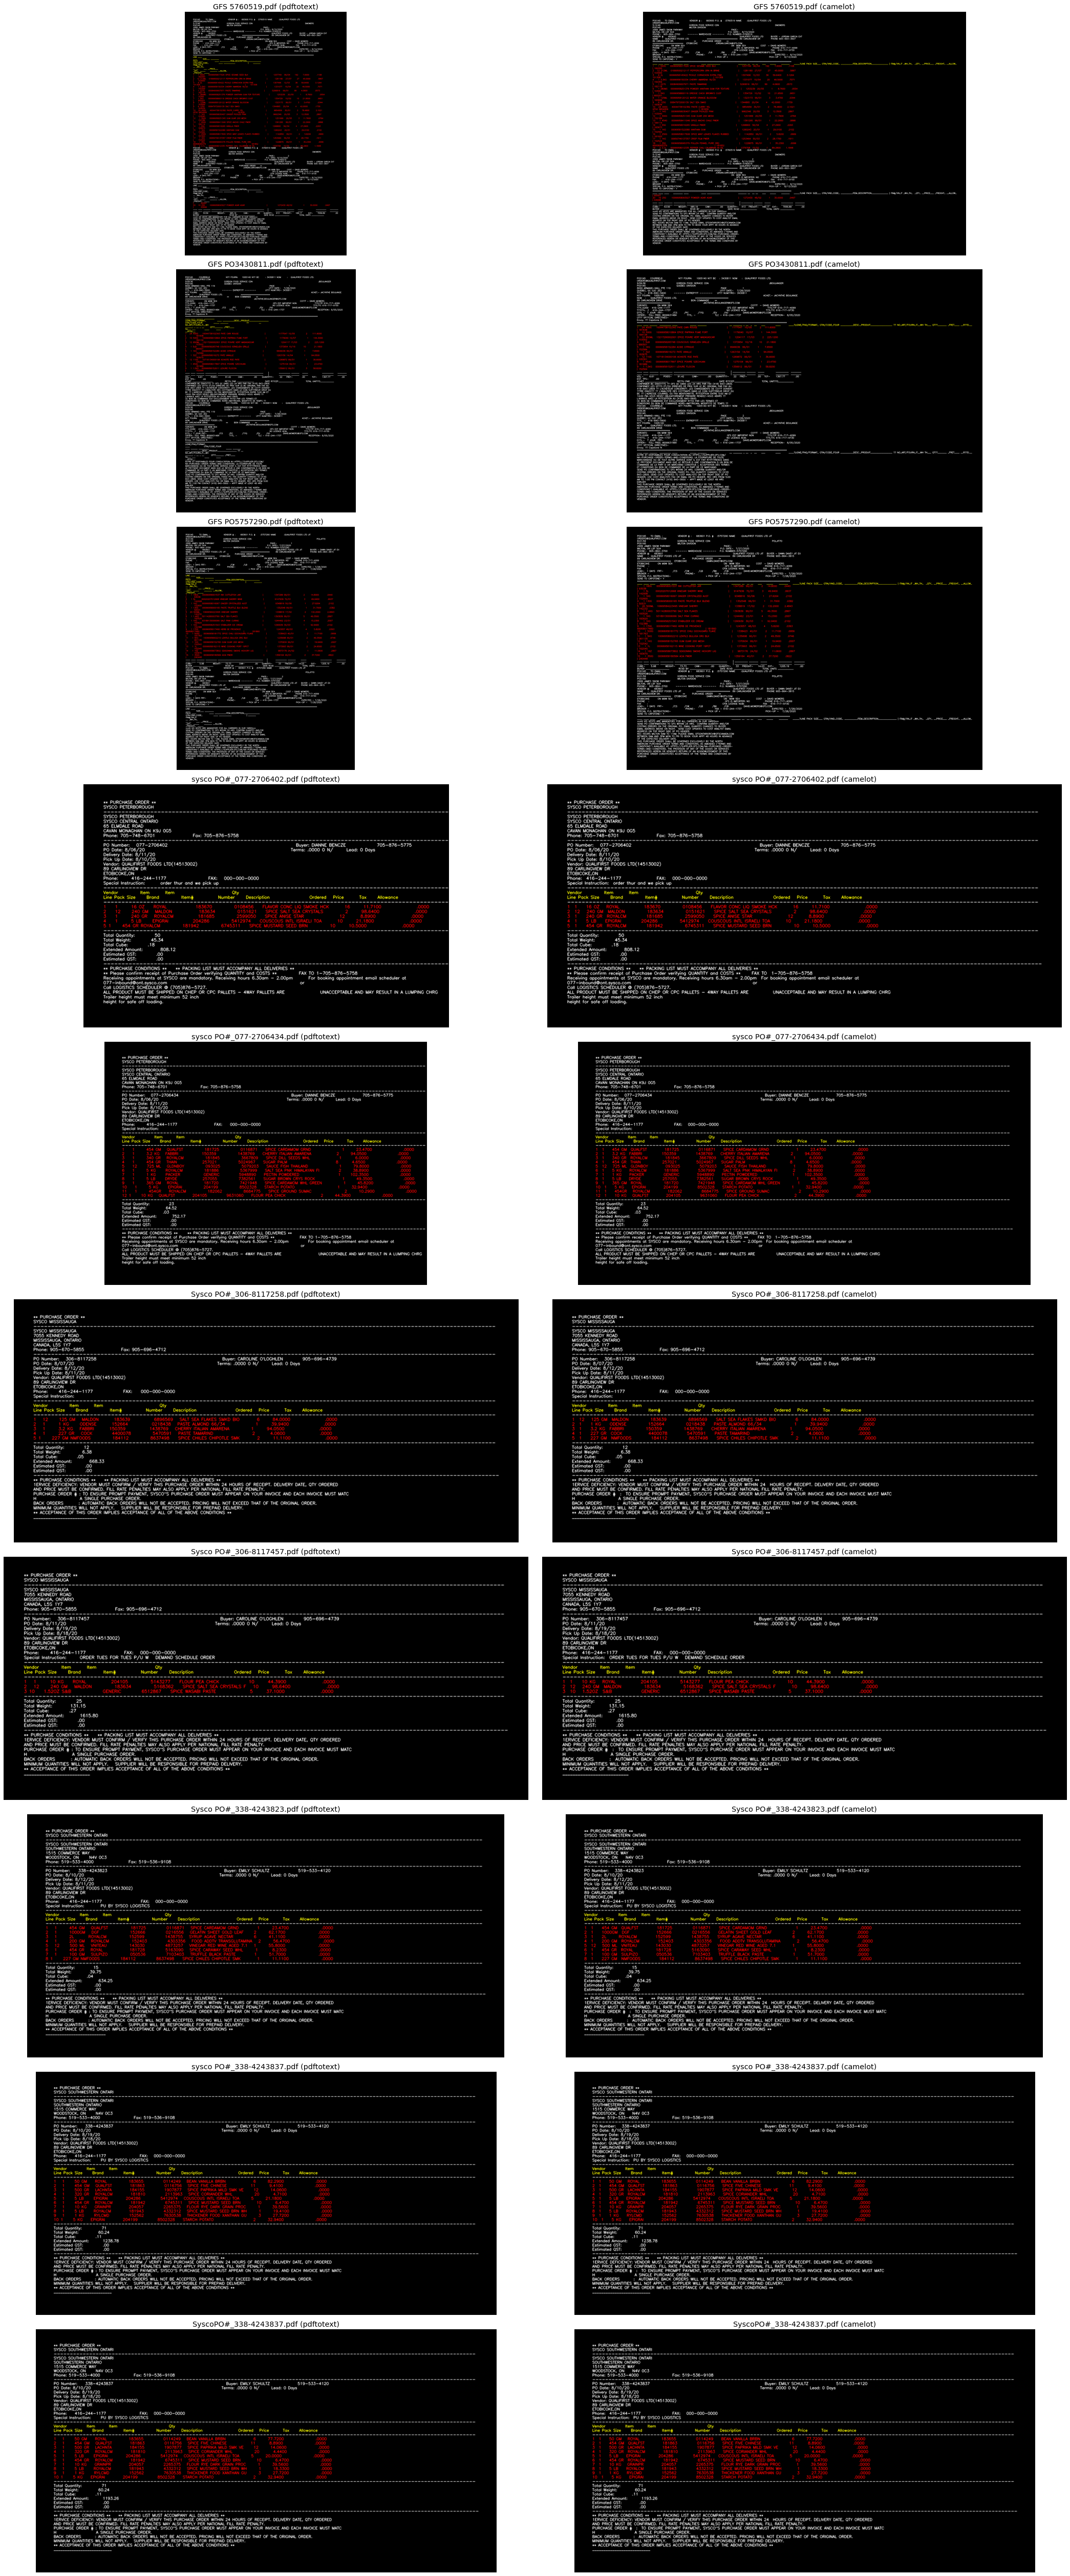

In [10]:
parse_mtds = ["pdftotext", "camelot"]

params = {"axes.titlesize": "X-large"}
plt.rcParams.update(params)

fig, ax = plt.subplots(len(pdf_pths), len(parse_mtds),
                       figsize=(30, 70))

for i, fl in enumerate(pdf_pths):
    for j, mt in enumerate(parse_mtds):
        ax[i, j].axis("off")
        ax[i, j].title.set_text(os.path.basename(pdf_pths[i]) +
                                " (" + parse_mtds[j] + ")"  )
        ax[i, j].imshow(make_pdf_image(pdf_pths[i], parse_mtds[j]))
        fig.tight_layout()

